In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


from flame_net.lib_uti import count_learnable_params
from flame_net.libSiva import CSolverSiva
#from flame_net.uti_plot import *
import os

from flame_net.libSiva import libSiva
from flame_net.libData import libData


# to extract an isoline 
#import matplotlib._cntr as cntr
import pickle

%matplotlib inline

#np.random.seed(seed=1653)


In [2]:
device = torch.device('cuda')
bRNN=False
T_in=1
data_channel = 1 # model.data_channel


In [3]:
models=[
        {'model_name_detail':'Fourier2D_m64_64w20cfdL1536_rho8_share_skip_best','nu':None,
         'sys_type':'cfd',
         'cfd':'L1536_rho8',
         'Nx':512, 'Ny':819, 'yB':np.array( [-0.7, 2.5])*np.pi,
         'nStep':1,'Tout':8},
        #{'model_name_detail':'Conv2D_cfdL1536_rho8_16_32_64_64_128_128_256_256_conv_all_best','nu':None,
        # 'sys_type':'cfd',
        # 'cfd':'L1536_rho8',
        # 'Nx':512, 'Ny':512, 'yB':np.array( [-0.7, 2.5])*np.pi,
        # 'nStep':1,'Tout':8}
        {'model_name_detail':'Conv2D_cfdL1536_rho8e_4_55_66_6_7_7_7_7_inception_less_o10_best','nu':None,
         'sys_type':'cfd',
         'cfd':'L1536_rho8',
         'Nx':512, 'Ny':512, 'yB':np.array( [-0.7, 2.5])*np.pi,
         'nStep':1,'Tout':8}
        #{'model_name_detail':'Fourier_m32w20nu07_share_skip'               ,'nu':0.07,'nStep':1,'Tout':20},
]

list__init_str = ['rand_FFT_2_8','rand_simple','rand_FFT_2_8','rand_simple' ]
#list__init_str_LongTerm=[3]
cfdsys_all = [
  {'cfd':'L1536_rho8', 'nu':0.02, 'SivaEq':CSolverSiva([0.02]), 'N':512 ,'list_randseed':[66,1217,2916,16616] }
  #{'nu':0.02, 'SivaEq':CSolverSiva([0.02]), 'N':512 ,'list_randseed':[5,1216,6,10] },
  #{'nu':0.07, 'SivaEq':CSolverSiva([0.07]), 'N':128 ,'list_randseed':[32,81,101,112] } 
]

N= 512 ,dt_Output= 0.015 ,nu_list = [0.02] ,nu_extention_list = [0.02] ,NumOutPut_dt= [37]
ActiveNoise_Amplitude=0.000000,stepfeq=1,k = 0 


In [4]:
def load_pkl( m ):
    str_filename = m['model_name_detail'] 
    if str_filename.find('_ep') >=0: 
        str_filename  = str_filename[ : str_filename.find('_ep') ]
    if str_filename.find('_best')>=0:
        str_filename  = str_filename[ : str_filename.find('_best') ]
    open_file=open('./checkpoints/'+str_filename+ 'trainlog.pkl','rb')
    output_dict= pickle.load(open_file)
    open_file.close()
    #return output_dict    
    train_residual = np.array ( [ os for os  in output_dict['list_output_info'] ] )
    return train_residual 
    
def plot_training_resid( m, list_iy=[4,5], ys='log',ix=0):
    train_residual = load_pkl( m)
    line_style = ['r-', 'g-.','b--','k.']
    for idx, y in enumerate(list_iy):
        plt.plot( train_residual[:,ix], train_residual[:,y], line_style[idx])
        #plt.plot( train_residual[:,ix], train_residual[:,y],'b-')
    plt.yscale(ys)
    
    return [ train_residual[:, y ][-1] for  y in list_iy ]

def print_train_info( list_iy=[4,5,1], models=models ):
    for idx, m in enumerate( models):
        train_residual = load_pkl( m)
        #----------------
        if 'ONet' in m['model_name_detail']:
            method='ONet'
        elif  'Fourier' in m['model_name_detail']:
            method='Fourier'
        elif  'Conv' in m['model_name_detail']:
            method='Conv'
        #----------------
        print(idx, method, m['nu'], m['nStep'] ,m['Tout'],  [ train_residual[:, y ][-1] for  y in list_iy ] ) 

In [5]:
print_train_info()

0 Fourier None 1 8 [0.016015810492656213, 0.025107288733124733, 232.32515186164528]
1 Conv None 1 8 [0.03167243482488574, 0.04049744829535484, 112.86061573890038]


[0.036007626761568254]

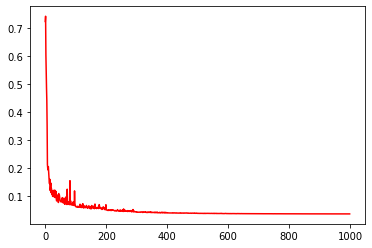

In [6]:
plot_training_resid (  models[1], [3],  ys='linear' )

In [7]:
def load_sys_xy_curv(sys):
    picklefilename = './Data_PRE_LaminarFlame/' + sys['cfd']+'.pkl'
    open_file = open(picklefilename, "rb")
    loaded_list = pickle.load(open_file)
    open_file.close()

    ##############################################
    N_mesh   = loaded_list['N']
    x        = np.arange(N_mesh)
    ################################################
    dyScale  = loaded_list['dyScale']
    #y3       = loaded_list['y3']/dyScale
    xy_curv  = loaded_list['xy_curv']
    y_simple = loaded_list['y_simple'][::10]/dyScale
    y0Ref    = np.average( y_simple,  axis = 1)
    ################################################
    x        =                         x /N_mesh         #  * 2*np.pi
    #y3      = (y3      - y0Ref.reshape(-1,1,1))/N_mesh    #  * 2*np.pi
    y_simple = ( y_simple- y0Ref.reshape(-1,1) )  /N_mesh  #  * 2*np.pi

    #min_y = 9999.
    #max_y = -9999.
    for idx, xy_each in enumerate( xy_curv ):
        xy_each[:,0] =( ( xy_each[:,0]/dyScale) - y0Ref[idx] ) /N_mesh  #*2*np.pi
        xy_each[:,1] =    xy_each[:,1]                         /N_mesh  #*2*np.pi

        xy_each[:,0] *= 2*np.pi
        xy_each[:,1] = (xy_each[:,1]-0.5)*2*np.pi
        
        #min_y = np.min( (min_y, np.min(xy_each[:, 0]) ) )
        #max_y = np.max( (max_y, np.max(xy_each[:, 0]) ) )
    ##############################################

    #Ly = max_y-min_y
    sys['xyCurv'] = xy_curv
    return sys

for sys in cfdsys_all:
    sys = load_sys_xy_curv(sys)

In [8]:
cfdsys_all[0]['cfd']

'L1536_rho8'

In [9]:
def get_2d_cfd_sys(cfd,cfdsys_all=cfdsys_all):
    for sys in cfdsys_all:
        if sys['cfd']== cfd :
            return sys
    raise ValueError('did not find cfd sys')
    
def get_rand_1d_d0(sys,list__init_str=list__init_str):
    #n = len(list__init_str)
    d0_all=[]
    for  init_str, randseed in zip( list__init_str, sys['list_randseed'] )  :
        np.random.seed(seed= randseed )
        d0 = sys['SivaEq'].get_init_func_from_txt( init_str )()
        d0_all.append(d0)
    return  np.array( d0_all )

#def get_d0_from_nu(i_which,nu):
#    return  get_d0(i_which, get_sys(nu) )
#def get_d0_all_from_nu(nu):
#    sys = get_sys(nu)
#    d0_all=[]
#    for i_which in range( len(sys['list_randseed']) ): 
#        d0 = get_d0(i_which, sys )
#        d0_all.append(d0)
#    return np.array( d0_all )
#def update_sys(sys):
    #d0_all   = get_d0_all_from_nu( sys['nu'] )
    #TotalTimeStep=2001
    #list_d_an=[]
    # --- init starting from either rand_FFT or rand ---
    #for d0 in d0_all:
    #    d_an = sys['SivaEq'].generate_dsol_single(TotalTimeStep, sys['nu'], d0)  # d_an.shape ==numTotalTimeStep,  N
    #    print('d_an.shape=', d_an.shape)
    #    list_d_an.append(d_an) 
    # --- init starting from a long-term soluton ---
    #for i_pick_longterm in list__init_str_LongTerm:
    #    d0 = list_d_an[i_pick_longterm][-1]
    #    d_an = sys['SivaEq'].generate_dsol_single(TotalTimeStep, sys['nu'], d0) 
    #    print('d_an.shape=', d_an.shape)
    #    list_d_an.append(d_an) 
    #sys['list_d_an'] = np.array( list_d_an)
    #sys['x'] = np.linspace(-1,1,sys['N'],endpoint=False)*np.pi 
    #sys['list_NormalizedTotalLen_an'] = libData.dsol_to_whole_length(sys['x'], sys['list_d_an'])
    #return sys



In [10]:

def load_model( model_name_detail):
    LocalFull_filename_Saved_Model =  './checkpoints/' + model_name_detail
    model = torch.load( LocalFull_filename_Saved_Model, map_location='cuda')
    print(model_name_detail, ' loaded in: count_learnable_params =' + str( count_learnable_params(model) ))
    return model

def get_model(name, models=models, bLoadModel=True):
#def get_model(name, nu,nStep,Tout,models=models, bLoadModel=True):
    if 'fno' in name.casefold():
        name_internal = 'fourier'
    elif 'cnn' in name.casefold() or 'cas' in name.casefold():
        name_internal = 'conv'
    elif 'onet' in name.casefold():
        name_internal = 'onet'
        
    for m in models:
        if name_internal in m['model_name_detail'].casefold()  : #and  m['nu']==nu and   m['nStep']==nStep and   m['Tout']==Tout: 
            if 'model' not in m  and bLoadModel==True:
                m['model'] = load_model( m['model_name_detail'] )
            return m
    raise ValueError('did not find model')

   


In [11]:

def update_model_pred(m):
    #if 'model' not in m:
    m['model'] = load_model( m['model_name_detail'] )

    m['x'] =libSiva.get_x( m['Nx'] ) 
    m['y'] =np.linspace(  m['yB'][0],m['yB'][1], m['Ny'] )    
    #m['xx,yy'] =lambda x: np.meshgrid(m['x'], m['y'], indexing='ij')
    
    list_pred = get_model_pred(m)
    # list_pred.shape == (4, 512,819, 2000)
    m['list_pred'] = np.moveaxis(list_pred,-1,1)
    print('list_pred.shape=', m['list_pred'].shape)

    #----
    #nu = m['nu']
    #sys = get_sys(nu)    
    #----

    #m['list_d_an'] = sys['list_d_an']
    #m['list_NormalizedTotalLen_an'] = sys['list_NormalizedTotalLen_an']
    
    #m['sys'] = sys
    #m['x'] = sys['x']
    
    #m['list_NormalizedTotalLen_pred'] = libData.dsol_to_whole_length(m['x'], m['list_pred']  )
    return m

def get_model_pred(m):
    Nx    = m['Nx'] 
    Ny    = m['Ny'] 
    yB    = m['yB'] 
    T_in  = 1 #  m['T_in']
    nStep = m['nStep']
    
    nTotalLength = 2000
    #G2D_model = torch.zeros((1, Nx, Ny, nTotalLength+1 ), dtype=torch.float)
    
    #nu    = m['nu'] 
    #nStep = m['nStep']
    
    #d0    = get_d0_all_from_nu(nu)
    #sys = get_sys(nu)
    #d0=sys['list_d_an'][:,0,:] 
    
    sys = get_2d_cfd_sys( m['cfd'])

    #--------
    yRef0=0
    yRef0_torch = torch.tensor( yRef0, dtype=torch.float32,device=device).reshape(-1, 1)
    
    #----------------------
    #d0 = (np.random.rand(m['Nx']) - 0.5) * 0.02
    
    d0_all = get_rand_1d_d0(sys)
    
    #G2D_model[0, :, :, 0] =  torch.tensor( 
    #     np.tanh( libData.dsol_single_to_Levelsetsol(x, d0, m['Nx'],m['Ny'],m['yB'], 'ylevel')   ) - yRef0,  dtype=torch.float)
    #d0_torch = G2D_model[0, :, :, 0]
    #d0_torch = torch.tensor(d0,dtype=torch.float).unsqueeze(-1)

    d0_all_torch=[]
    for d0 in d0_all:
        d0_torch = torch.tensor(  np.tanh( 
               libData.dsol_single_to_Levelsetsol(m['x'], d0, m['Nx'],m['Ny'],m['yB'], 'ylevel')   ) - yRef0,  dtype=torch.float).unsqueeze(-1)
        d0_all_torch.append(d0_torch)
    
    d0_all_torch = torch.stack( d0_all_torch, dim=0 )
    #print('d0_all_torch.shape',d0_all_torch.shape)

    
    pred = torch.zeros(  ( d0_all_torch.shape[0], Nx,Ny, nTotalLength//nStep + 1), dtype=torch.float )
    pred[...,0:1] = d0_all_torch
    with torch.no_grad():
        model = m['model']
        xx = d0_all_torch
        xx = xx.to(device)
        for t in range(nTotalLength//nStep):
            im = model(xx) # , torch.tensor([nu]))
            #---------------------
            #if bExtra_Reconstruct_G2D==True:
            #    im_np = libData.correct_tanh_ylevel(im[0,:,:,0].detach().numpy(),Nx,Ny,yB)
            #    im[0,:,:,0] = torch.tensor(im_np)

            im[:,:, :10,:]  = 1.
            im[:,:, -10:,:] = -1.
            im = torch.clamp(im+ yRef0_torch, min=-1., max=1.)-yRef0_torch
            #--------------------
            #if torch.any( torch.isnan(im) ) == True :
            #    if 'fourier' in m['model_name_detail'].casefold() and m['Tout']==20:
            #        print('the solution diverged at step', t, ', you can try change rand_seed of', torch.where(torch.isnan(im))[0] )
            #        raise ValueError("Nan")
            #        break
            #--------------------
            
            #if t == 0:
            #    pred = torch.cat((xx, im), -1)
            #else:
            #    pred = torch.cat((pred, im), -1)
            pred[...,(t+1):(t+2)] = im
            
            xx = torch.cat((xx[..., 1 * data_channel:], im), dim=-1)
            if (t+1)%100==0: 
                print('',end='.')
            
    return pred.detach().cpu().numpy()



In [12]:
models[1]=update_model_pred(models[1])


Conv2D_cfdL1536_rho8e_4_55_66_6_7_7_7_7_inception_less_o10_best  loaded in: count_learnable_params =1857637


/apps/Arch/software/PyTorch/1.9.0-fosscuda-2020b/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


....................list_pred.shape= (4, 2001, 512, 512)


In [13]:
models[0]=update_model_pred(models[0])


Fourier2D_m64_64w20cfdL1536_rho8_share_skip_best  loaded in: count_learnable_params =6556877
....................list_pred.shape= (4, 2001, 512, 819)


In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation, PillowWriter 
import numpy as np


def Animate_G2D(list_model_name, gif_filename=None, i__plotpick =[(1), (2)] , dt_nSkip=1, len_t=2000):
    
    fig, axs = plt.subplots( len(list_model_name),len(i__plotpick),sharex=True, sharey=True, figsize=(1.5*6*len(i__plotpick) ,1.5*4*len(list_model_name)) )
    #fig, axs = plt.subplots( len(list_model_name),2, sharex=True, sharey=True, figsize=(1.5*12 ,1.5*4*len(list_model_name)) )
    global cfs_model
    cfs_model=[]
    for i_model, model_name in enumerate(list_model_name):
        
        m = get_model( model_name )
        
        #for i, ax in zip( i__plotpick, axs[i_model:i_model+1,:].reshape(-1) ) :
        for i, ax in zip( i__plotpick, axs[i_model:i_model+1].reshape(-1) ) :

            cfs_model.append( ax.contourf( m['y'], m['x'],  m['list_pred'][i,0], 
                                 levels = np.linspace(-1,1,21,endpoint=True), vmin=-1, vmax=1 ) )

            ax.set_aspect('equal')
            #---------------------
            #for ax in ax_cols:
            ax.set_ylim ( [-np.pi, np.pi] )
            ax.set_yticks( [-np.pi, 0, np.pi] ); 
            ax.set_yticklabels(['$-\pi$', '0', '$\pi$'] ,  fontsize=14,rotation='vertical')
            ax.set_ylabel('$2\pi x_1/\Lambda$', fontsize=14, labelpad=0)
            
            #ax.set_xlim ( [-0.3, 8.2*np.pi] )
            ax.set_xlabel('$2\pi x_2/\Lambda$', fontsize=14 )
            ax.set_xticks( [ 0,  2*np.pi] );    
            ax.set_xticklabels(['0','2$\pi$' ] , fontsize=14 )
            
            #---------------------
    for ax in axs.flat:
        ax.label_outer()    
    
    plt.subplots_adjust(left=0.03,right=0.98,bottom=0.03, top=0.975,  wspace=0.02, hspace=0.02)
    
    list_RightText = [ nmodel_name for nmodel_name in list_model_name[::-1]]
    dy =(1-0.1)/len(list_model_name) 
    for idx in range( len(list_model_name)):
        ypos = 0.1+(0.5+idx)*dy
        fig.text(0.985, ypos, list_RightText[idx],  rotation='vertical',fontsize=16 ,transform=plt.gcf().transFigure) #, weight='bold')

    #cbaxes = fig.add_axes([0.96-0.03, 0.35, 0.02, 0.4])        
    #cbar = fig.colorbar(cs,   shrink=1, ticks=[-1, 0, 1] , cax = cbaxes )  #ax=axs,
    #cbar.ax.set_ylabel('$\Psi(x_1,x_2;t_j)$',fontsize=16)


    #fig.text( 0.25, 0.96, 'j='+str(i_t__plotpick[0][-1]) , ha='center',fontsize=16)
    #fig.text( 0.7, 0.96, 'j='+str(i_t__plotpick[1][-1]) , ha='center',fontsize=16 )    

    def animate(t, dt_nSkip):
        global cfs_model
        
        idx =0
        for i_model, model_name in enumerate(list_model_name):
            m = get_model( model_name )
            
            #for i, ax in zip( i__plotpick, axs[i_model:i_model+1].reshape(-1) ) :
            for i, ax in zip( i__plotpick, axs[i_model:i_model+1,:].reshape(-1) ) :
                
            #for idx, ax in enumerate(axs.reshape(-1)):
                for coll in cfs_model[idx].collections:  # save memerory
                    coll.remove()
                cfs_model[idx] = ax.contourf(m['y'], m['x'],  m['list_pred'][i,t*dt_nSkip],  levels = np.linspace(-1,1,21,endpoint=True), vmin=-1, vmax=1 ) 
                idx = idx + 1
        
        return 
    
        
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len_t//dt_nSkip, fargs=(dt_nSkip,))
    if gif_filename is not None:
        ani.save(gif_filename, writer=PillowWriter(fps=10))
    else:
        from IPython.display import HTML
        HTML(ani.to_jshtml())
        ani
        
            



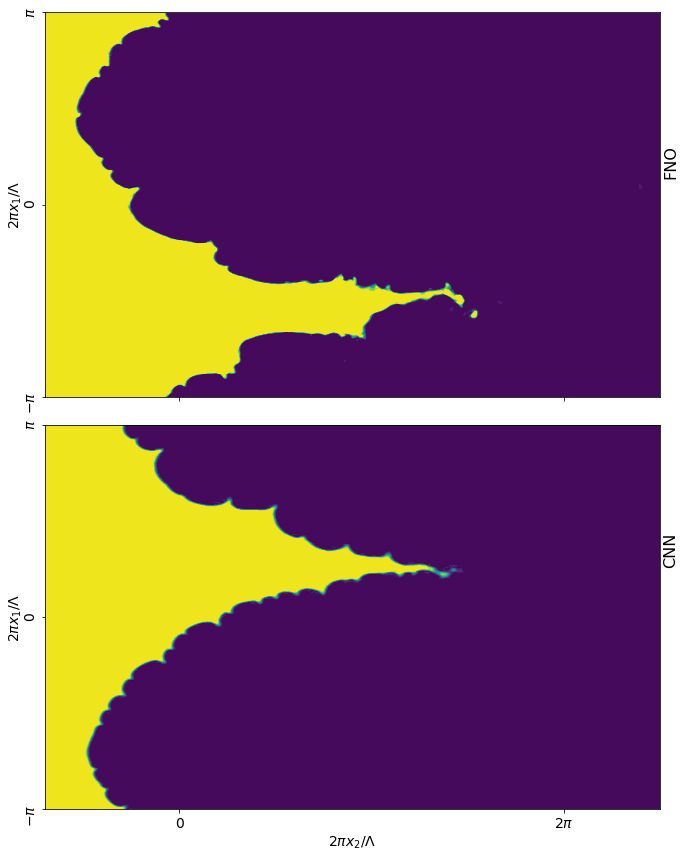

In [18]:
#%matplotlib inline
#Animate_G2D(list_model_name= ['FNO','CNN'],  gif_filename='G2D_L536_rho8_compact.gif', i__plotpick =[2, 1], dt_nSkip=1, len_t=1000 )

# For ludwig nobel
#Animate_G2D(list_model_name= ['FNO','CNN'],  gif_filename='G2D_L536_rho8_compact1.gif', i__plotpick =[2], dt_nSkip=1, len_t=1000 )


In [14]:
def extract_all_level_curves(m):
    list_pred_curv=[]
    for pred_2d in m['list_pred'] :
        list_pred_curv.append( extract_levelzero_curves(m['x'], m['y'], pred_2d) )
        print('')
        print('')
    m['list_pred_curv'] = list_pred_curv
    return m
    
def extract_levelzero_curves(x, y, pred_2d):
    # m['y'], m['x'] , m['list_pred'][0,:,:,:]
    level_zero= 0
    list_pred_xy0level=[]
    for idx, each_pred in  enumerate( pred_2d) :
        cs = plt.contour( y, x, each_pred, [level_zero] )
        p=cs.collections[0].get_paths() #[0]
        #v = p.vertices    
        list_pred_xy0level.append( p ) 
        if (idx+1)%100==0:
            print('',end='.')
    return list_pred_xy0level

....................

....................

....................

....................



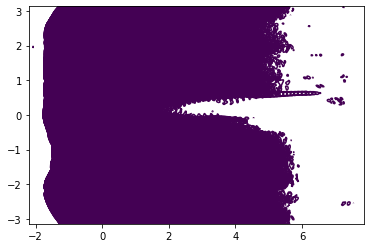

In [15]:
m = models[0]
m = extract_all_level_curves(m)

....................

....................

....................

....................



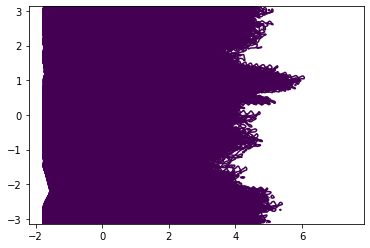

In [16]:
m = models[1]
m = extract_all_level_curves(m)

In [17]:
def plot_disp_long(list_model_name, png_filename=None,
                   list_i_t_plot= [0,  50, 100,200,400 ,600,800,1000,1200,1400,1600,1800,2000],
                   nRow=2,nCol=2,rd=100 ):
    
    figsize=(0.9*12,0.9*4.9*len(list_model_name))
    #---------------------------------------------------------------------------
    fig, axs = plt.subplots(nRow*len(list_model_name),nCol, sharex=True, sharey=True, figsize= figsize )
    for i_model, model_name in enumerate(list_model_name):

        #------------------
        #m = get_model(model_name , nu, nStep, Tout )
        m = get_model( model_name )
        #------------------
        
        for ax, pred in zip( axs[i_model*nRow:(i_model+1)*nRow,...].reshape(-1),  m['list_pred_curv'][:nRow*nCol] ) :

            for i in list_i_t_plot:
                d = (i)/rd
                if i >= 0: 
                    #linecolor = '-r' if i%2==0 else '-b'
                    for idx, each_line_seg in enumerate( pred[i]):
                        v = each_line_seg.vertices    

                        if idx==0:
                            h_pred, = ax.plot(  v[:,0] + d,   v[:,1] )  
                        else:
                            h_pred, = ax.plot(  v[:,0] + d,   v[:,1],  color = h_pred.get_color())  


                #h_ref, = ax.plot(  d_an[i] + d,   x,'--k' , linewidth=1 )


            #---------------------
            #for ax in ax_cols:
            ax.set_yticks( [-np.pi, 0, np.pi] ); 
            ax.set_yticklabels(['$-\pi$', '0', '$\pi$'] ,  fontsize=14,rotation='vertical')
            ax.set_ylabel('$2\pi x_1/\Lambda$ ', fontsize=14, labelpad=0)

            ax.set_xlim ( [-0.3, 10.5*np.pi] )
            ax.set_xlabel('$2\pi x_2 /\Lambda  $ + j/'+str(rd), fontsize=14 )
            ax.set_xticks( [ 0,  2*np.pi,  4*np.pi,  6*np.pi , 8*np.pi,10*np.pi] );    
            ax.set_xticklabels(['0','2$\pi$', '4$\pi$' ,'6$\pi$', '8$\pi$', '10$\pi$' ] , fontsize=14 )
            #---------------------
            ax.set_aspect('equal')
            
    for ax in axs.flat:
        ax.label_outer()
    #fig.legend([h_ref,h_pred],['Ref',model_name], bbox_to_anchor=(0.6,0.1),ncol=2,fontsize=14  )

    fig.tight_layout()
    #plt.subplots_adjust(wspace=0.02,hspace=0.02)
    
    #----
    plt.subplots_adjust(left=0.045, right=0.978, top=0.985,bottom=0.06 ,wspace=0.01, hspace=0.01)
    list_RightText = list_model_name[::-1]
    dy =(1-0.01)/4
    for idx in range(4):
        ypos = 0.01+(0.5+idx)*dy
        fig.text(0.98, ypos, list_RightText[idx//2],  rotation='vertical',fontsize=16 ,transform=plt.gcf().transFigure, weight='bold')
    #---------------------    
    
    if png_filename is not None:
        print('savefig: ', png_filename)
        if 'eps' in png_filename:
            plt.savefig(png_filename,format = 'eps')
        else:
            plt.savefig(png_filename, dpi=300)
    #return fig,axs

savefig:  disp_L1536_rho8.eps


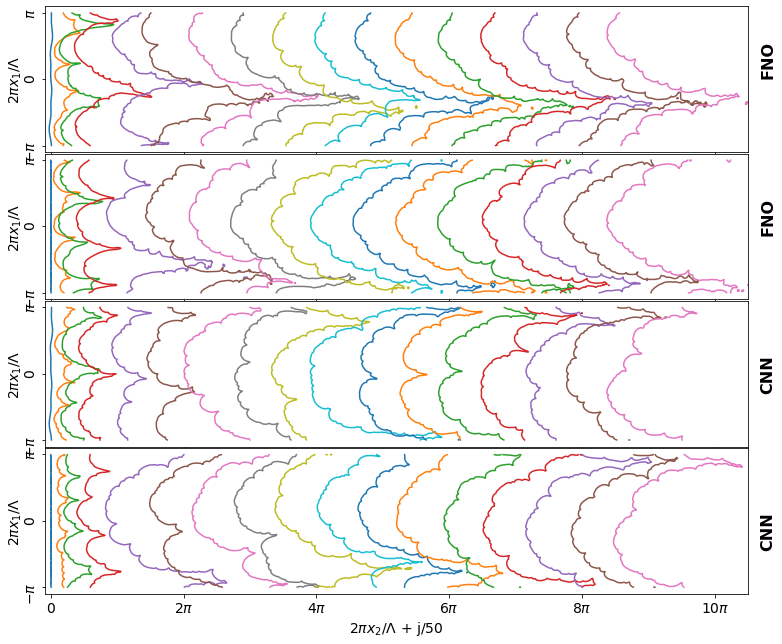

In [18]:
#list_i_t_plot = [0,  50, 100,200,400 ,600,800,1000,1200,1400,1600,1800,2000]
list_i_t_plot = [0, 25,50, 100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400]
plot_disp_long( ['FNO','CNN'],list_i_t_plot=list_i_t_plot,nRow=2,nCol=1,rd=50, png_filename= 'disp_L1536_rho8.eps' )

In [19]:
#list_i_t_plot = [0, 25,50, 100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400]
#plot_disp_long('CNN',list_i_t_plot=list_i_t_plot,nRow=2,nCol=1,rd=50, png_filename='disp_cnn_L1536_rho8.eps' )


In [20]:
def plot_disp_long_cfd(cfd='L1536_rho8',
                       list_i_t_plot = [0, 50, 100,200,300,400,500,600,700],
                       png_filename='disp_cfd_L1536_rho8.png',
                       rd = 50
                      ):
    sys = get_2d_cfd_sys('L1536_rho8')
    #x = m['x']
    #figsize=(12,6)
    figsize=(8,4)
    #---------------------------------------------------------------------------
    fig, ax = plt.subplots(1,1,figsize= figsize )

    #axs = np.array([axs])
    #for ax, xyCurv in zip(axs.reshape(-1),  sys['xyCurv'] ) :

    for i in list_i_t_plot:
        d = (i)/rd
        if i >= 0: 
            #linecolor = '-r' if i%2==0 else '-b'
            yx = sys['xyCurv'][i]
            h_pred, = ax.plot(  yx[:,0] + d,   yx[:,1], '.' , markersize=.05 )  
        #h_ref, = ax.plot(  d_an[i] + d,   x,'--k' , linewidth=1 )


    #---------------------
    #for ax in ax_cols:
    ax.set_yticks( [-np.pi, 0, np.pi] ); 
    ax.set_yticklabels(['$-\pi$', '0', '$\pi$'] ,  fontsize=14,rotation='vertical')
    ax.set_ylabel('$2\pi x_1/\Lambda$', fontsize=14, labelpad=0)

    ax.set_xlim ( [-0.3, 5.8*np.pi] )
    ax.set_xlabel('$2\pi x_2/\Lambda$ +j/'+str(rd), fontsize=14 )
    ax.set_xticks( [ 0,  2*np.pi,  4*np.pi  ] );    
    ax.set_xticklabels(['0','2$\pi$', '4$\pi$'  ] , fontsize=14 )
    #---------------------
    ax.set_aspect('equal')

    #for ax in axs.flat:
    #    ax.label_outer()
    #plt.subplots_adjust(left=0.035, right=0.98, top=0.99, bottom=0.08, wspace=0.02)
    #plt.subplots_adjust(left=0.065, right=0.98, top=0.99, bottom=0.13, wspace=0.05)
    #plt.subplots_adjust(left=0.045, right=0.98, top=0.99, bottom=0.1, wspace=0.02,hspace=0.02)

    #fig.legend([h_ref,h_pred],['Ref',model_name], bbox_to_anchor=(0.6,0.1),ncol=2,fontsize=14  )

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.02,hspace=0.02)

    
    #for idx in range(2):
    #    ypos = 0.01+(0.5+idx)*dy
    #    fig.text(0.98, ypos, list_RightText[idx//2],  rotation='vertical',fontsize=14 ,transform=plt.gcf().transFigure) #, weight='bold')

    if png_filename is not None:
        print('savefig: ', png_filename)
        if 'eps' in png_filename:
            plt.savefig(png_filename,format = 'eps')
        else:
            plt.savefig(png_filename, dpi=300)

savefig:  disp_cfd_L1536_rho8.png


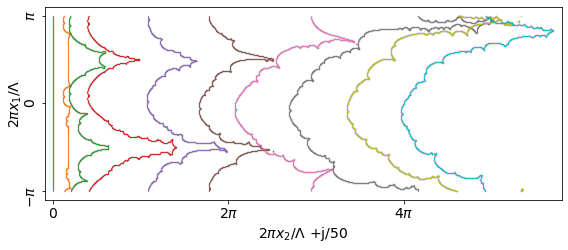

In [21]:
plot_disp_long_cfd(cfd='L1536_rho8',list_i_t_plot = [0, 25,50, 100,200,300,400,500,600,700],png_filename='disp_cfd_L1536_rho8.png')

In [22]:
def plot_G2D(list_model_name, png_filename=None, i_t__plotpick =[(1,200), (1,2000)] ):
    
    fig, axs = plt.subplots( len(list_model_name),2, sharex=True, sharey=True, figsize=(12 ,4*len(list_model_name)) )
    #fig, axs = plt.subplots( len(list_model_name),2,  figsize=(12,4*len(list_model_name)) ,constrained_layout=True )

    for i_model, model_name in enumerate(list_model_name):
        
        m = get_model( model_name )
        
        for i_t, ax in zip( i_t__plotpick, axs[i_model:i_model+1,:].reshape(-1) ) :

            cs = ax.contourf( m['y'], m['x'],  m['list_pred'][i_t], 
                                 levels = np.linspace(-1,1,21,endpoint=True), vmin=-1, vmax=1 )

            ax.set_aspect('equal')
            #---------------------
            #for ax in ax_cols:
            ax.set_ylim ( [-np.pi, np.pi] )
            ax.set_yticks( [-np.pi, 0, np.pi] ); 
            ax.set_yticklabels(['$-\pi$', '0', '$\pi$'] ,  fontsize=14,rotation='vertical')
            ax.set_ylabel('$2\pi x_1/\Lambda$', fontsize=14, labelpad=0)
            
            #ax.set_title( 'j='+str(i_t[1]) )

            #ax.set_xlim ( [-0.3, 8.2*np.pi] )
            ax.set_xlabel('$2\pi x_2/\Lambda$', fontsize=14 )
            ax.set_xticks( [ 0,  2*np.pi] );    
            ax.set_xticklabels(['0','2$\pi$' ] , fontsize=14 )
            
            #---------------------

    #plt.subplots_adjust(wspace=0.02,hspace=0.02)
    
    for ax in axs.flat:
        ax.label_outer()    
    #fig.tight_layout()
    
    
    plt.subplots_adjust(left=0.045,right=0.915-0.03, top=0.95,  wspace=0.02, hspace=0.02)
    
    list_RightText = [ nmodel_name for nmodel_name in list_model_name[::-1]]
    dy =(1-0.1)/len(list_model_name) 
    for idx in range( len(list_model_name)):
        ypos = 0.1+(0.5+idx)*dy
        fig.text(0.92-0.03, ypos, list_RightText[idx],  rotation='vertical',fontsize=16 ,transform=plt.gcf().transFigure) #, weight='bold')

    cbaxes = fig.add_axes([0.96-0.03, 0.35, 0.02, 0.4])        
    cbar = fig.colorbar(cs,   shrink=1, ticks=[-1, 0, 1] , cax = cbaxes )  #ax=axs,
    cbar.ax.set_ylabel('$\Psi(x_1,x_2;t_j)$',fontsize=16)

    #cbar.ax.tick_params(labelsize=16)
    #cbar.ax.tick_params(labelsize=14)
    #---------------------
    #----        
    #print (get(cb).Position)
    #set(cb,'Position',[a(1)+dx a(2)+dy w h])%

    fig.text( 0.25, 0.96, 'j='+str(i_t__plotpick[0][-1]) , ha='center',fontsize=16)
    fig.text( 0.7, 0.96, 'j='+str(i_t__plotpick[1][-1]) , ha='center',fontsize=16 )    
    
    if png_filename is not None:
        print('savefig: ', png_filename)
        if 'eps' in png_filename:
            plt.savefig(png_filename,format = 'eps')
        else:
            plt.savefig(png_filename, dpi=300)
    

savefig:  G2D_L536_rho8.png


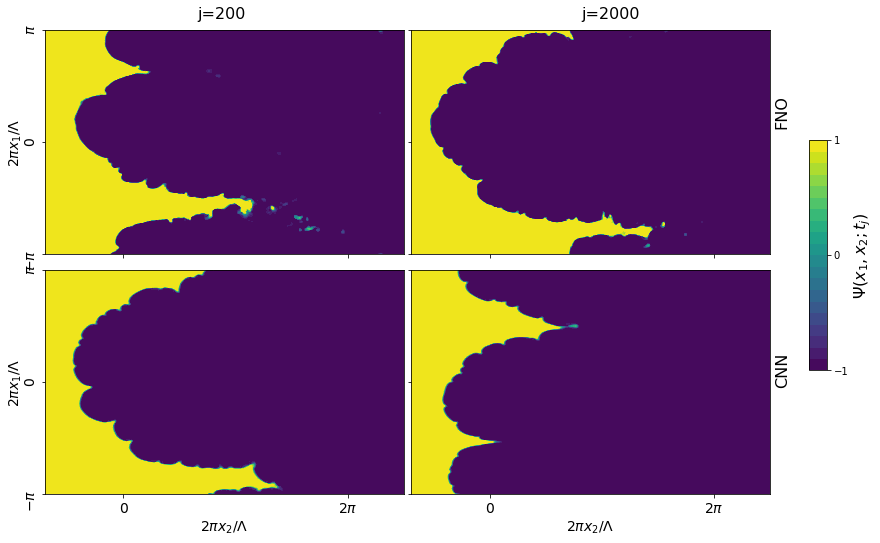

In [23]:
#plot_G2D(list_model_name= ['FNO','CAS'],  png_filename='G2D_fourier_L536_rho8.png', i_t__plotpick =[(1,200), (1,2000)] )
plot_G2D(list_model_name= ['FNO','CNN'],  png_filename='G2D_L536_rho8.png', i_t__plotpick =[(1,200), (1,2000)] )


In [24]:
[(1,200), (1,2000)][0][-1]

200

In [25]:
cb

NameError: name 'cb' is not defined

In [ ]:
#plot_G2D(model_name='CNN',  png_filename='G2D_cnn_L536_rho8.png', i_t__plotpick =[(0,200), (0,2000)] )
